# Load python packages for data handling and plotting

In [67]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting
mpl.rcParams['image.cmap'] = 'hot_r' # change default color map

%matplotlib inline

Uproot package for ROOT > numpy data conversion: https://github.com/scikit-hep/uproot

In [68]:
import uproot
import uproot._connect.to_pandas # load the pandas connection

Load some statistics function

In [69]:
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, iqr, norm

Increase default font size

In [70]:
font = {'size'   : 16}
mpl.rc('font', **font)

## Load input data

In [71]:
file_name = "https://alobanov.web.cern.ch/alobanov/public/HGCAL_TBOct2018_ntuple_run_925.root"
#file_name = "https://alobanov.web.cern.ch/alobanov/public/ntuple_636.root"
file_content = uproot.open(file_name)

Inspect file content (ROOT TTrees)

In [72]:
file_content.allkeys()

['rechitntupler;1',
 'rechitntupler/hits;6',
 'rechitntupler/hits;5',
 'trackimpactntupler;1',
 'trackimpactntupler/impactPoints;1',
 'XCETntupler;1',
 'XCETntupler/XCET;1',
 'MCPntupler;1',
 'MCPntupler/MCP;1']

## Load HGCAL data into pandas dataframe

In [73]:
hits = file_content["rechitntupler/hits"]

In [74]:
# Select branches
branches = ['event', 'run',
            'rechit_layer', 'rechit_x', 'rechit_y', 'rechit_z',
            'rechit_noise_flag','rechit_energy']

In [75]:
cache = {} # cache data

Flatten means: one 'hit' per row

In [76]:
%%time
df_hits = hits.pandas.df(branches, cache = cache, entrystop = 1000, flatten = True)

CPU times: user 15 s, sys: 1.43 s, total: 16.5 s
Wall time: 1min 11s


In [77]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 948644 entries, (0, 0) to (999, 948)
Data columns (total 8 columns):
event                948644 non-null uint32
run                  948644 non-null uint32
rechit_layer         948644 non-null uint32
rechit_x             948644 non-null float32
rechit_y             948644 non-null float32
rechit_z             948644 non-null float32
rechit_noise_flag    948644 non-null bool
rechit_energy        948644 non-null float32
dtypes: bool(1), float32(4), uint32(3)
memory usage: 29.9 MB


In [78]:
df_hits.head()

event  run  rechit_layer  rechit_x  rechit_y  rechit_z  \
entry subentry                                                           
0     0             1  925             1 -0.000009  2.250488     13.32   
      1             1  925             1 -0.974487  1.687744     13.32   
      2             1  925             1 -1.948975  2.250488     13.32   
      3             1  925             2 -0.974487  1.687744     14.21   
      4             1  925             2 -1.948975  2.250488     14.21   

                rechit_noise_flag  rechit_energy  
entry subentry                                    
0     0                     False       4.062109  
      1                     False      34.071411  
      2                     False      11.076063  
      3                     False      62.524364  
      4                     False       3.603892

Filter low-energy hits

In [79]:
df_hits = df_hits[df_hits.rechit_energy > 0.5]

## Correlations

In [80]:
gb_events = df_hits.groupby('event')

e_sums = gb_events['rechit_energy'].sum()
n_hits = gb_events['rechit_energy'].size()

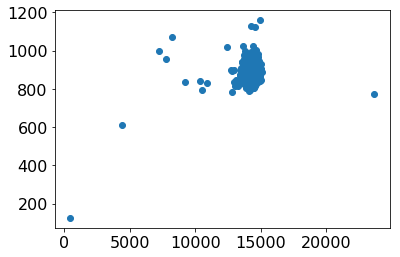

In [81]:
plt.plot(e_sums, n_hits, 'o')

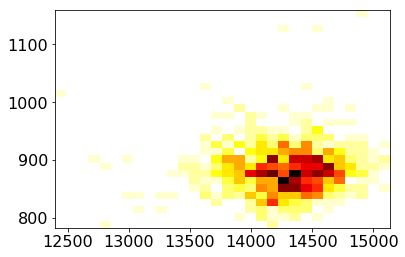

In [82]:
sel = abs(e_sums-e_sums.median()) < 3000
sel &= abs(n_hits-n_hits.median()) < 400

r = plt.hist2d(e_sums[sel], n_hits[sel], 30)
#plt.plot(e_sums[sel], n_hits[sel], '.')

Correlate layer energies

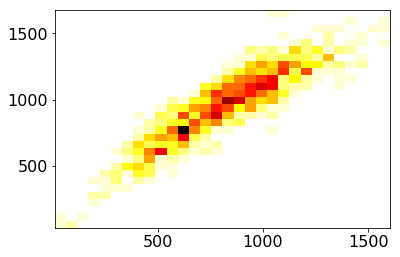

In [83]:
sel = df_hits.rechit_layer == 5
ene_lay_5 = df_hits[sel].groupby('event')['rechit_energy'].sum()

sel = df_hits.rechit_layer == 6
ene_lay_6 = df_hits[sel].groupby('event')['rechit_energy'].sum()

r = plt.hist2d(ene_lay_5, ene_lay_6, 30)

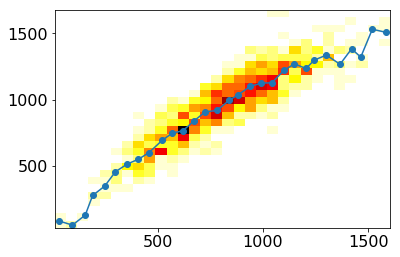

In [84]:
x = ene_lay_5
y = ene_lay_6

x_med, y_med = binned_statistic(x, [x,y], bins = 30, statistic = 'median').statistic

plt.hist2d(x,y, 30)
plt.plot(x_med, y_med, 'o-')

# Add "tracker" information

We use "Delay Wire Chambers" for tracking. Storing the reconsturcted tracks in the same ROOT file:

In [85]:
tracks = file_content["trackimpactntupler/impactPoints"]

In [86]:
tr_branches = ['event', 'run', 'ntracks','trackChi2_X',
 'trackChi2_Y', 'dwcReferenceType', 'm_x', 'm_y', 'b_x', 'b_y']

In [87]:
%%time
df_tracks = tracks.pandas.df(tr_branches, entrystop = 1000, flatten = True)

CPU times: user 181 ms, sys: 20 ms, total: 201 ms
Wall time: 829 ms


In [88]:
df_tracks.head()

,event,run,ntracks,trackChi2_X,trackChi2_Y,dwcReferenceType,m_x,m_y,b_x,b_y
0,1,925,0,-999.000000,-999.000000,0,-999.000000,-999.000000,-999.000000,-999.000000
1,2,925,1,0.020270,0.053286,13,-0.000408,0.000516,-1.476436,1.135535
2,3,925,1,2.203852,3.497892,15,-0.000434,0.000449,-0.797085,1.268801
3,4,925,1,0.711565,2.461902,13,-0.000392,0.000472,-1.077939,1.021026
4,5,925,1,3.120249,0.378781,15,-0.000321,0.000496,-3.067071,1.602151


Plot the beamspot

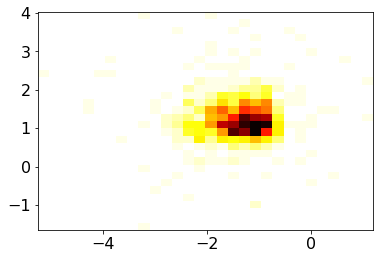

In [89]:
sel = df_tracks.ntracks == 1
r = plt.hist2d(df_tracks[sel].b_x, df_tracks[sel].b_y, 30)

Filter events without tracks

In [90]:
sel = df_tracks.ntracks == 1
df_tracks = df_tracks[sel]

# Merge HGC and DWC data frames

One can merge different dfs by index or column. In our case we want to merge the events:

Set the index of the dfs as event

In [91]:
df_hits.set_index('event', inplace = True)
df_tracks.set_index('event', inplace = True)

In [92]:
df_all = df_hits.join(df_tracks, 
                      rsuffix = '_dwc', # give a suffix for duplicate columns
                      how = 'inner', # only preserve events present in both dfs
                     )

In [93]:
df_all.head()

,run,rechit_layer,rechit_x,rechit_y,rechit_z,rechit_noise_flag,rechit_energy,run_dwc,ntracks,trackChi2_X,trackChi2_Y,dwcReferenceType,m_x,m_y,b_x,b_y
event,,,,,,,,,,,,,,,,
2,925,1,-0.000009,-1.125244,13.32,False,1.741884,925,1,0.02027,0.053286,13,-0.000408,0.000516,-1.476436,1.135535
2,925,1,-0.974487,1.687744,13.32,False,63.245773,925,1,0.02027,0.053286,13,-0.000408,0.000516,-1.476436,1.135535
2,925,1,-0.974487,0.562622,13.32,False,0.564570,925,1,0.02027,0.053286,13,-0.000408,0.000516,-1.476436,1.135535
2,925,1,-1.948975,1.125244,13.32,False,3.143707,925,1,0.02027,0.053286,13,-0.000408,0.000516,-1.476436,1.135535
2,925,1,3.897949,2.250488,13.32,False,0.571444,925,1,0.02027,0.053286,13,-0.000408,0.000516,-1.476436,1.135535


Compute shower barycentre in HGCAL

In [94]:
def get_baryX(event):
    return np.sum(event.rechit_x * event.rechit_energy) / event.rechit_energy.sum()

def get_baryY(event):
    return np.sum(event.rechit_y * event.rechit_energy) / event.rechit_energy.sum()

In [95]:
gb_event = df_all.groupby('event')
baryX = gb_event.apply(get_baryX)
baryY = gb_event.apply(get_baryY)

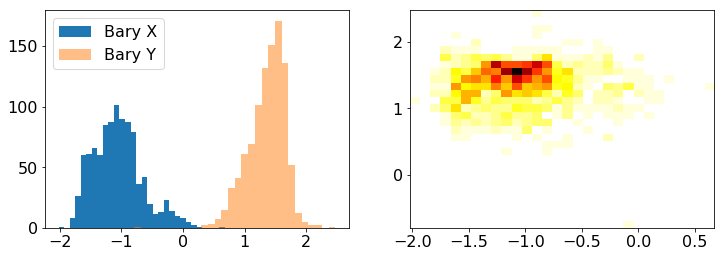

In [120]:
plt.figure(figsize = (12,4))
plt.subplot(121)

r = plt.hist(baryX, 30, label = 'Bary X')
r = plt.hist(baryY, 30, label = 'Bary Y', alpha = .5)

plt.legend()

plt.subplot(122)

r = plt.hist2d(baryX, baryY, 30)

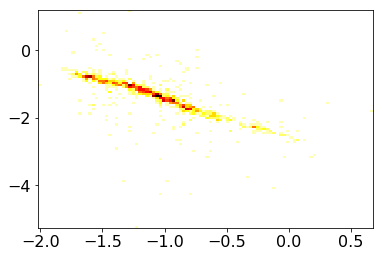

In [119]:
r = plt.hist2d(baryX, df_tracks.b_x, 100)#, norm = LogNorm())

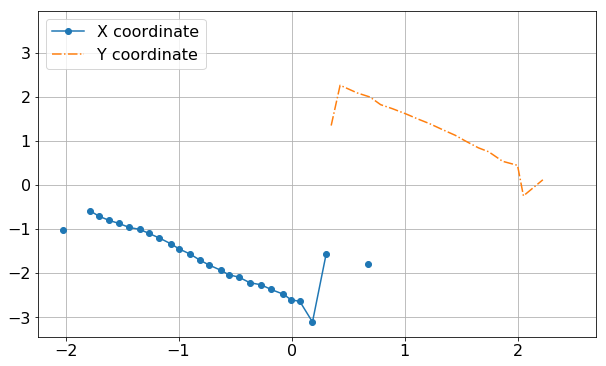

In [117]:
plt.figure(figsize = (10,6))

x = baryX
y = df_tracks.b_x
x_med, y_med = binned_statistic(x, [x,y], bins = 30, statistic = 'median').statistic
plt.plot(x_med, y_med, 'o-', label = 'X coordinate')

x = baryY
y = df_tracks.b_y
x_med, y_med = binned_statistic(x, [x,y], bins = 30, statistic = 'median').statistic
plt.plot(x_med, y_med, '-.', label = 'Y coordinate')

plt.legend()
plt.grid()